In [1]:
import os
from modulus.sym.hydra import to_absolute_path
from csv_rw import csv_to_dict
import csv
import numpy as np
import glob
from multiprocessing import Process
from fwdFacingStep import ffs, param_ranges, Re, Ho, Lo
from shortNames import shortNameDict


In [2]:
def readFile(file_path):
    with open(file_path, "r") as datafile:
        data = []
        reader = csv.reader(datafile, delimiter=",")
        for row in reader:
            columns = [row[1]]
            data.append(columns)
        last_row = float(data[-1][0])
        return last_row

In [7]:
# Read and Compare Delta Cp

from os import listdir
from modulus.sym.domain.validator import Validator
from statistics import mean, stdev
from shortNames import name2data


ansysFilePath="./ansysDPsValidation.csv"
resultsFilePath="./results.csv"
outputsPath="./outputs/fwdFacingStep"

dirSkip = [".hydra", "init"]

# models = listdir(outputsPath)
# models.sort()

models = ["physicsOnlyFC@500k", "dataOnly1800FC@500k", "data1800PlusPhysicsLambda01FC@500k", "data1800PlusPhysicsLambda1FC@500k", "pressureDataPlusPhysicsLambda01FC@500k", "pressureDataPlusPhysicsLambda1FC@500k"]

models += ["physicsOnly@500k", "dataOnly1800@500k", "data1800PlusPhysicsLambda01@500k", "data1800PlusPhysicsLambda1@500k", "pressureDataPlusPhysicsLambda01@500k", "pressureDataPlusPhysicsLambda1@500k",
"data1800PlusPhysicsLambda01@100k2pO@500k", "data1800PlusPhysicsLambda1@100k2pO@500k"]

dirSkip = [".hydra", "init", "initFC", "vtp", ]
skip = ["@100k", "@300k"]

diffSumSkip = ["DP 5","DP 36","DP 79","DP 86"]


with open(ansysFilePath, "r") as ansysFile,  open(resultsFilePath, "w") as resultsFile:
        reader = csv.reader(ansysFile, delimiter=",")
        writer = csv.writer(resultsFile, delimiter=",")
        diffDSP= {}
        diffUSP= {}
        diffDCp= {}
        # diffDSPAbs= {}
        # diffUSPAbs= {}
        # diffDCpAbs= {}
        diffDSPPer= {}
        diffUSPPer= {}
        diffDCpPer= {}
        trueDCpList = []

        for i, row in enumerate(reader): # loop over validation points
            if i == 0:
                # add columns for difference modulus vs ansys
                row.insert(5, "Diff Delta Cp [%]")
                # row.insert(7, "Diff Delta Cptot [%]")
                # writer.writerow(row)
            else:
                trueDSP = float(row[5])
                trueUSP = float(row[6])
                trueDeltaCp = float(row[4])
                trueDCpList.append(trueDeltaCp)
                
                for model in models:
                        # print('model: ', model)
                        if model in dirSkip:
                                # print("skipping ", model)
                                continue
                        
                        monitorFilePath = os.path.join(outputsPath, model, "monitors")
                        # print('monitorFilePath: ', monitorFilePath)
                        # read pressure monitors
                        filePattern="downstreamPressure_" + row[0].replace(" ","") + "_*"
                        monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        # print('monitorFiles: ', monitorFile)
                        DSP=readFile(monitorFile[0])
                        # filePattern="downstreamPressureTot_" + row[0].replace(" ","") + "_*"
                        # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        # DSPtot=readFile(monitorFile[0])
                        filePattern="upstreamPressure_" + row[0].replace(" ","") + "_*"
                        monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        USP=readFile(monitorFile[0])
                        # filePattern="upstreamPressureTot_" + row[0].replace(" ","") + "_*"
                        # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        # USPtot=readFile(monitorFile[0])
                        
                        # calculate modulus pressure drop and difference modulus vs ansys
                        deltaCp=2*(USP-DSP)
                        
                        
                        
                        
                        # Absolute Percentage MAPE
                        if row[0] not in diffSumSkip:
                            if model not in diffDSPPer.keys():
                                diffDSPPer[model] = [abs(100*(DSP - trueDSP)/trueDSP)]
                            else:
                                diffDSPPer[model].append(abs(100*(DSP - trueDSP)/trueDSP))
                                
                            if model not in diffUSP.keys():
                                diffUSPPer[model] = [abs(100*(USP - trueUSP)/trueUSP)]
                            else:
                                diffUSPPer[model].append(abs(100*(USP - trueUSP)/trueUSP))
                                
                            if model not in diffDCp.keys():
                                diffDCpPer[model] = [abs(100*(deltaCp - trueDeltaCp)/trueDeltaCp)]
                            else:
                                diffDCpPer[model].append(abs(100*(deltaCp - trueDeltaCp)/trueDeltaCp))
                        
                        
                        # Non Absolute Percentage 
                        # if row[0] not in diffSumSkip:
                        #     if model not in diffDSP.keys():
                        #         diffDSP[model] = [100*(DSP - trueDSP)/trueDSP]
                        #     else:
                        #         diffDSP[model].append(100*(DSP - trueDSP)/trueDSP)
                                
                        #     if model not in diffUSP.keys():
                        #         diffUSP[model] = [100*(USP - trueUSP)/trueUSP]
                        #     else:
                        #         diffUSP[model].append(100*(USP - trueUSP)/trueUSP)
                                
                        #     if model not in diffDCp.keys():
                        #         diffDCp[model] = [100*(deltaCp - trueDeltaCp)/trueDeltaCp]
                        #     else:
                        #         diffDCp[model].append(100*(deltaCp - trueDeltaCp)/trueDeltaCp)
                                
                        # Non Absolute E
                        if row[0] not in diffSumSkip:
                            if model not in diffDSP.keys():
                                diffDSP[model] = [DSP - trueDSP]
                            else:
                                diffDSP[model].append(DSP - trueDSP)
                                
                            if model not in diffUSP.keys():
                                diffUSP[model] = [USP - trueUSP]
                            else:
                                diffUSP[model].append(USP - trueUSP)
                                
                            if model not in diffDCp.keys():
                                diffDCp[model] = [deltaCp - trueDeltaCp]
                            else:
                                diffDCp[model].append(deltaCp - trueDeltaCp)
                        
                        # add modulus results to table
                        # modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [deltaCptot] + [diffDeltaCptot] + [DSP] + [DSPtot] + [USP] + [USPtot]
                        # writer.writerow(modRow)
            # Add deviation sum
        # firstRow = ["Model", "DSP Mean", "DSP Min", "DSP Max", "USP Mean", "USP Min", "USP Max", "DCp Mean", "DCp Min", "DCp Max"]
        # firstRow = ["Arch", "Const.", "$W_d$", "DCp Mean", "DCp Std", "DSP Mean", "DSP Std", "USP Mean", "USP Std"]
        firstRow = ["Arch", "Const.", "$W_d$", "MAE DCp", "MAPE DCp", "ME DCp", "E DCp Std"]
        
        writer.writerow(firstRow)
        
        data = []
        
        for model in models:
            if model in dirSkip or "100k" in model.split("@")[-1] or "300k" in model.split("@")[-1]:
            # if model in dirSkip:
                # print("skipping ", model)
                continue
            
            # maxDSP = max(diffDSP[model])
            # maxUSP = max(diffUSP[model])
            # maxDCp = max(diffDCp[model])

            # minDSP = min(diffDSP[model])
            # minUSP = min(diffUSP[model])
            # minDCp = min(diffDCp[model])
            
            meanErrorDSP = mean(diffDSP[model])
            meanErrorUSP = mean(diffUSP[model])
            meanErrorDCp = mean(diffDCp[model])
            
            meanAbsErrorDSP = mean(abs(np.array(diffDSP[model])))
            meanAbsErrorUSP = mean(abs(np.array(diffUSP[model])))
            meanAbsErrorDCp = mean(abs(np.array(diffDCp[model])))
            
            stdDSP = stdev(diffDSP[model])
            stdUSP = stdev(diffUSP[model])
            stdDCp = stdev(diffDCp[model])
            
            meanAbsPerErrorDSP = mean(abs(np.array(diffDSPPer[model])))
            meanAbsPerErrorUSP = mean(abs(np.array(diffUSPPer[model])))
            meanAbsPerErrorDCp = mean(abs(np.array(diffDCpPer[model])))
            
            modelData = name2data(model)
            
            # modelData[]
                
            # row = [label, meanErrorDSP, minDSP, maxDSP, meanErrorUSP, minUSP, maxUSP, meanErrorDCp, minDCp, maxDCp]
            # row = [modelData['train'], modelData['Wd'], modelData['2PStep'], modelData['arch'], meanErrorDCp, stdDCp, meanErrorDSP, stdDSP, meanErrorUSP, stdUSP]
            row = [modelData['train'], modelData['Wd'], modelData['2PStep'], modelData['arch'], meanAbsErrorDCp, meanAbsPerErrorDCp, meanErrorDCp, stdDCp]
            
            data.append(row)
            
        dataSorted = data
        
        for row in dataSorted:
            
            writer.writerow(row)
            # latexStr = label
            latexStr = ''
            for value in row[0:3]:
                # print('f ',value)
                latexStr += str(value) + ' & '
            latexStr += str(row[3])
            for value in row[4:]:
                # print('d ', value)
                valueF = round(float(value), 3)
                # latexStr += "%.3f" % valueF
                latexStr += " & " + "%.3f" % valueF
            latexStr += " \\\\"
            print(latexStr)                    
                                


Physics & - & - & FCNN & 0.889 & 7.957 & -0.889 & 0.261 \\
Data & - & 500 & FCNN & 0.153 & 0.946 & -0.041 & 0.416 \\
Data+Physics & 0.1 & 500 & FCNN & 0.024 & 0.194 & -0.010 & 0.031 \\
Data+Physics & 1 & 500 & FCNN & 0.059 & 0.392 & -0.022 & 0.146 \\
Pressure Data+Physics & 0.1 & - & FCNN & 0.051 & 0.493 & 0.051 & 0.022 \\
Pressure Data+Physics & 1 & - & FCNN & 0.057 & 0.548 & 0.047 & 0.044 \\
Physics & - & - & FNN & 0.145 & 1.370 & -0.099 & 0.180 \\
Data & - & 500 & FNN & 0.632 & 5.238 & 0.392 & 0.870 \\
Data+Physics & 0.1 & 500 & FNN & 0.107 & 0.895 & -0.069 & 0.119 \\
Data+Physics & 1 & 500 & FNN & 0.144 & 1.192 & -0.104 & 0.194 \\
Pressure Data+Physics & 0.1 & - & FNN & 0.191 & 1.800 & -0.180 & 0.136 \\
Pressure Data+Physics & 1 & - & FNN & 0.351 & 2.711 & -0.344 & 0.482 \\
Data+Physics & 0.1 & 100 & FNN & 0.134 & 1.284 & -0.108 & 0.147 \\
Data+Physics & 1 & 100 & FNN & 0.124 & 1.177 & -0.095 & 0.138 \\


In [ ]:
# Read and Compare Delta Cp OLD

from os import listdir
from modulus.sym.domain.validator import Validator


ansysFilePath="./ansysDPsValidation.csv"
resultsFilePath="./results.csv"
outputsPath="./outputs/fwdFacingStep"

# models = ["old_dataPlusPhysics3600@300k", "data3600PlusPhysicsLambda05@300k", "data3600PlusPhysicsLambda1@300k", "old_physicsOnly@500k", "physicsOnly@500k"]

dirSkip = [".hydra", "init"]

models = listdir(outputsPath)
models.sort()

models = ["data1800PlusPhysicsLambda01@500k"]


diffSumSkip = ["DP 5","DP 36","DP 79","DP 86"]


with open(ansysFilePath, "r") as ansysFile,  open(resultsFilePath, "w") as resultsFile:
        reader = csv.reader(ansysFile, delimiter=",")
        writer = csv.writer(resultsFile, delimiter=",")
        diffDict= {}
        for model in models:
                diffDict[model] = 0
                # print(type(diffDict[model]))
        for i, row in enumerate(reader):
                if i == 0:
                        # add columns for difference modulus vs ansys
                        row.insert(5, "Diff Delta Cp [%]")
                        # row.insert(7, "Diff Delta Cptot [%]")
                        writer.writerow(row)
                else:
                        # add ansys results to table
                        row.insert(5, "-")
                        # row.insert(7, "-")
                        writer.writerow(row)
                        for model in models:
                                print(model)
                                if model in dirSkip:
                                        print("skipping ", model)
                                        continue
                                
                                monitorFilePath = os.path.join(outputsPath, model, "monitors")
                                # read pressure monitors
                                filePattern="downstreamPressure_" + row[0].replace(" ","") + "_*"
                                monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                DSP=readFile(monitorFile[0])
                                # filePattern="downstreamPressureTot_" + row[0].replace(" ","") + "_*"
                                # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                # DSPtot=readFile(monitorFile[0])
                                filePattern="upstreamPressure_" + row[0].replace(" ","") + "_*"
                                monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                USP=readFile(monitorFile[0])
                                # filePattern="upstreamPressureTot_" + row[0].replace(" ","") + "_*"
                                # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                # USPtot=readFile(monitorFile[0])
                                
                                # calculate modulus pressure drop and difference modulus vs ansys
                                deltaCp=2*(USP-DSP)
                                # deltaCptot=2*(USPtot-DSPtot)
                                deltaCpTrue = float(row[4])
                                diffDeltaCp=100*(deltaCp-deltaCpTrue)/deltaCpTrue
                                # diffDeltaCptot=100*(deltaCptot-float(row[6]))/float(row[6])
                                
                                if row[0] not in diffSumSkip:
                                        diffDict[model] += abs(diffDeltaCp)
                                
                                # add modulus results to table
                                modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [DSP] + [USP]
                                # modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [deltaCptot] + [diffDeltaCptot] + [DSP] + [DSPtot] + [USP] + [USPtot]
                                writer.writerow(modRow)
        # Add deviation sum
        for model in models:
                deviationRow = ["Sum " + model] + ["-"] + ["-"] + ["-"] + ["-"] + [diffDict[model]] + ["-"] + ["-"]
                writer.writerow(deviationRow)
                
                                
                                


In [59]:
# Read Optimization Results

import csv
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
from shortNames import shortNameDict

resultsFilePath="./resultsOpt.csv"
ansysOptFilePath="./AnsysOpt.csv"
NnOptValidationPath="./NnOptValidation.csv"
resultsOpt_AnsysHeaderPath="./resultsOpt_AnsysHeader.csv"

dirSkip = [".hydra", "init"]

optResultsPath = "./optimizationResults/"
# optResultsPath = "./optimizationResultsReducedRange_fl/"

# models = listdir(optResultsPath)
# models.sort()

models = ["physicsOnly@500k", "dataOnly1800@500k", "data1800PlusPhysicsLambda01@500k", "data1800PlusPhysicsLambda1@500k", "pressureDataPlusPhysicsLambda01@500k", "pressureDataPlusPhysicsLambda1@500k",
"data1800PlusPhysicsLambda01@100k2pO@500k", "data1800PlusPhysicsLambda1@100k2pO@500k"]

# models = ["physicsOnlyFC@500k", "dataOnly1800FC@500k", "data1800PlusPhysicsLambda01FC@500k", "data1800PlusPhysicsLambda1FC@500k", "pressureDataPlusPhysicsLambda01FC@500k", "pressureDataPlusPhysicsLambda1FC@500k"]

with open(resultsFilePath, "w") as resultsFile, open(ansysOptFilePath, 'r') as ansysOptFile, open(NnOptValidationPath, 'r') as NnOptValidationFile, open(resultsOpt_AnsysHeaderPath, 'r') as resultsOpt_AnsysHeaderFile:
    writer = csv.writer(resultsFile, delimiter=",")
    reader = csv.reader(ansysOptFile, delimiter=",")
    readerNnOptValidation = csv.reader(NnOptValidationFile, delimiter=",")
    readerResultsOpt_AnsysHeader = csv.reader(resultsOpt_AnsysHeaderFile, delimiter=",")
    
    
    reader.__next__()
    readerNnOptValidation.__next__()
    readerResultsOpt_AnsysHeader.__next__()

    
    ansysOptDict ={}
    NnOptValidationDict={}

    for rows in zip(readerNnOptValidation, readerResultsOpt_AnsysHeader):
        validationRow = rows[0]
        nameRow = rows[1]
        name = nameRow[0].replace(';', ',').replace('FCNN, ', '').replace('FNN, ', '')
        
        if name not in NnOptValidationDict.keys():
            validationData = {}
            NnOptValidationDict[name] = validationData
        
        NnOptValidationDict[name][int(validationRow[1])] = validationRow[2:]
        
    # print(NnOptValidationDict)
        
    
    for row in reader:
        # print(row)
        ansysOptDict[row[1].replace(' ', '')] = row[2:5]
    
    # print(ansysOptDict)

    
    
    firstRow = ["model", "Re", "Lo", "Lo Diff", "Ho", "Ho Diff", "delta Cp", "deltaCp CFD", "diff deltaCp"]
    # firstRow = ["model", "Re", "Lo", "Ho", "delta Cp", "delta Cp Ref"]
    # firstRow = ["Arch", "Const.", "$W_d$", "DCp Mean", "DCp Std", "DSP Mean", "DSP Std", "USP Mean", "USP Std"]
    writer.writerow(firstRow)

    # title = "Fourier NN Optimal $L_o$"
    # title = "Fully Connected NN Optimal $L_o$"
    # plt.figure()
    # plt.title(title)

    # plotRe = [float(item[0]) for item in ansysOptDict.items()][2:]
    # plotLo = [float(item[1][0]) for item in ansysOptDict.items()][2:]
    
    # plt.plot(plotRe, plotLo, label='CFD Discrete')

    for model in models:
        if model in dirSkip:
            # print("skipping ", model)
            continue
            
        optPath = optResultsPath + model
        
        reStart = 300
        reEnd = 1000
        
        plotRe = []
        plotLo = []
        plotHo = []
        

        
        for reNr in range (reStart, reEnd+1, 100):
            
            plotRe.append(reNr)
            F = np.load(optPath + "/optResultsF" + str(reNr) + ".npy")
            X = np.load(optPath + "/optResultsX" + str(reNr) + ".npy")
            popF = np.load(optPath + "/popF" + str(reNr) + ".npy")
            popX = np.load(optPath + "/popX" + str(reNr) + ".npy") 
            # print("Re " + str(re) + " F: ", F)
            # print("Re " + str(reNr) + ": Lo = " + str(X[0]), " Ho = " + str(X[1]))
            
            modelStrSplit = model.split("@")
                
            if len(modelStrSplit) == 3:
                label = shortNameDict[modelStrSplit[0]] + ", $S_d=$" + modelStrSplit[1].split("k")[0] + "k" #+ shortNameDict[modelStrSplit[1].split("k")[-1]] #+ "@" + modelStrSplit[-1]
            elif len(modelStrSplit) == 2:
                label = shortNameDict[modelStrSplit[0]] #+ "@" + modelStrSplit[-1]
            
            label = label.replace('FCNN, ', '').replace('FNN, ', '')
            
            
            row = [label]
            # row += [reNr, X[0], X[0]-float(ansysOptDict[str(reNr)][0]), X[1], X[1]-float(ansysOptDict[str(reNr)][1]), F[0], NnOptValidationDict[label][reNr][-3]]
            row += [reNr,
                    X[0], 100*(X[0]-float(ansysOptDict[str(reNr)][0])) /float(ansysOptDict[str(reNr)][0]),
                    X[1], 100*(X[1]-float(ansysOptDict[str(reNr)][1])) /float(ansysOptDict[str(reNr)][1]),
                    F[0], NnOptValidationDict[label][reNr][-3],
                    100*(float(NnOptValidationDict[label][reNr][-3]) - float(ansysOptDict[str(reNr)][-1]))/float(ansysOptDict[str(reNr)][-1])]
            # print(row)
            
            # for csv export to ansys
            # row = [label.replace(',', ';')]
            # row += [reNr, X[0], X[1]]
            
            plotLo.append(X[0])
            plotHo.append(X[1])
            
            if reNr == reStart:
                latexStr = label.split(',')[0] + " & " + str(reNr)
            elif reNr == reStart + 100 and len(label.split(',')) > 1:
                latexStr = label.split(',')[1] + " & " + str(reNr)
            elif reNr == reStart + 200 and len(label.split(',')) > 2:
                latexStr = label.split(',')[2] + " & " + str(reNr)
            else:
                latexStr = " " + " & " + str(reNr)
            
            for value in row[2:]:
                # print(value)
                valueF = round(float(value), 2)
                latexStr += " & " + "%.2f" % valueF
            # latexStr += " & - "
            latexStr += " \\\\"
            

            
            writer.writerow(row)
            print(latexStr)
        print("\\midrule")
            
    #     plt.plot(plotRe, plotLo, label=label)
        
    # plt.xlabel("Re")
    # plt.ylabel("$L_o$")
    # plt.legend()
    # # plt.yscale("log")
    # plt.ylim(0.2, 0.5)
    # # plt.ylim(9.15, 9.4)
    # plt.show()


Physics & 300 & 0.20 & -0.13 & 0.10 & -75.58 & 12.44 & 12.83 & 2.24 \\
  & 400 & 0.20 & -22.27 & 0.34 & -16.34 & 11.22 & 11.44 & 1.20 \\
  & 500 & 0.20 & -32.05 & 0.33 & -15.79 & 10.41 & 10.67 & 1.53 \\
  & 600 & 0.20 & -37.11 & 0.33 & -14.87 & 9.85 & 10.14 & 1.96 \\
  & 700 & 0.20 & -39.64 & 0.33 & -14.65 & 9.47 & 9.74 & 2.36 \\
  & 800 & 0.20 & -41.70 & 0.33 & -14.43 & 9.16 & 9.43 & 2.65 \\
  & 900 & 0.20 & -44.01 & 0.33 & -13.76 & 8.97 & 9.18 & 2.96 \\
  & 1000 & 0.20 & -48.02 & 0.33 & -13.74 & 8.90 & 8.99 & 3.35 \\
\midrule
Data & 300 & 0.60 & 200.41 & 0.43 & 5.77 & 10.52 & 12.81 & 2.09 \\
  & 400 & 0.60 & 133.09 & 0.43 & 7.57 & 10.18 & 11.53 & 1.96 \\
  & 500 & 0.59 & 101.47 & 0.43 & 8.70 & 9.75 & 10.70 & 1.78 \\
  & 600 & 0.85 & 166.12 & 0.31 & -21.56 & 9.38 & 10.00 & 0.56 \\
  & 700 & 0.85 & 155.51 & 0.30 & -21.75 & 9.35 & 9.57 & 0.56 \\
  & 800 & 0.85 & 147.49 & 0.31 & -19.95 & 8.58 & 9.23 & 0.48 \\
  & 900 & 0.59 & 66.33 & 0.31 & -19.53 & 8.73 & 8.96 & 0.49 \\
  & 1000 & 0.85 

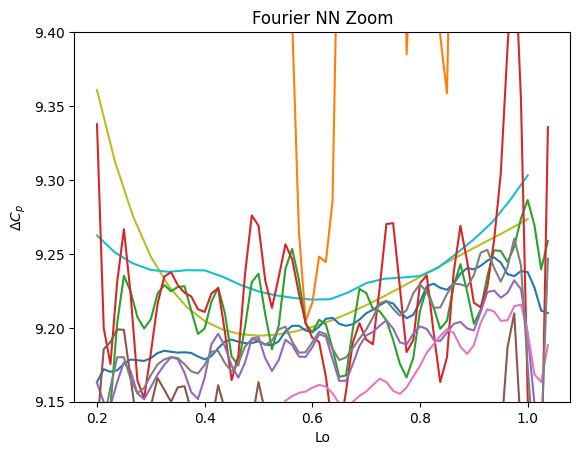

In [4]:
# Read Response Results


import csv
from os import listdir
import numpy as np
from brokenaxes import brokenaxes
import matplotlib.pyplot as plt
from shortNames import shortNameDict

# shortNameDict = {
#     "data1800PlusPhysicsLambda1": "D+P$\_W_d1$",
#     # "data1800PlusPhysicsLambda1": "D+P_L1",
#     "data1800PlusPhysicsLambda01": "D+P$\_W_d0.1$",
#     # "data1800PlusPhysicsLambda01": "D+P_L0.1",
#     "dataOnly1800": "D",
#     "physicsOnly": "P",
#     "physicsOnlyFC": "P FC",
#     "pressureDataPlusPhysicsLambda1": "PD+P",
#     "data1800PlusPhysicsLambda1FC" : "D+P\_FC$\_W_d1$",
#     "data1800PlusPhysicsLambda01FC" : "D+P\_FC$\_W_d01$",
#     "2pO": "ToP"
# }

# resultsFilePath="./resultsOpt.csv"

# dirSkip = ["dataOnly1800@500k", "pressureDataPlusPhysicsLambda1@500k", ""]
dirSkip = []

resultsPath = "./responseResults/"

# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@300k"]
# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@500k"]
# models = listdir(resultsPath)
# models.sort()

models = ["physicsOnly@500k", "dataOnly1800@500k", "data1800PlusPhysicsLambda01@500k", "data1800PlusPhysicsLambda1@500k", "pressureDataPlusPhysicsLambda01@500k", "pressureDataPlusPhysicsLambda1@500k",
"data1800PlusPhysicsLambda01@100k2pO@500k", "data1800PlusPhysicsLambda1@100k2pO@500k"]
# models += ["data1800PlusPhysicsLambda01_extraFreq@500k"]

# models = ["physicsOnlyFC@500k", "dataOnly1800FC@500k", "data1800PlusPhysicsLambda01FC@500k", "data1800PlusPhysicsLambda1FC@500k", "pressureDataPlusPhysicsLambda01FC@500k", "pressureDataPlusPhysicsLambda1FC@500k"]


# for L in ["1", "0.1"]:
for reNr in [800]:
    # for HoV in [0.35, 0.4, 0.45]:
    for HoV in [0.35]:
    # for HoV in [0.2, 0.3, 0.4]:
        # title = "Response $\Delta C_p$, Re = " + str(reNr) + ", Ho = " + str(HoV) # + ", $W_d$ = " + L
        # title = "Fully Connected NN"
        # title = "Fully Connected NN Zoom"
        # title = "Fourier NN"
        title = "Fourier NN Zoom"
        plt.figure()
        plt.title(title)
        
        #plot ansys response for comparison
        ansysFilePath = "./AnsysResponseRe" + str(reNr) + "Ho" + str(HoV) + ".csv"
        with open(ansysFilePath, "r") as ansysFile:
            x_vals_ans = []
            y_vals_ans = []
            reader = csv.reader(ansysFile, delimiter=",")
            for i in range(8):
                    reader.__next__()
            for row in reader:
                x_vals_ans.append(float(row[0]))
                y_vals_ans.append(float(row[1]))
        
        plt.plot(x_vals_ans, y_vals_ans, label="FVM Discrete Re", color='tab:olive')
        
        ansysFilePath = "./AnsysResponse100Re" + str(reNr) + "Ho" + str(HoV) + ".csv"
        with open(ansysFilePath, "r") as ansysFile:
            x_vals_ans = []
            y_vals_ans = []
            reader = csv.reader(ansysFile, delimiter=",")
            for i in range(8):
                    reader.__next__()
            for row in reader:
                x_vals_ans.append(float(row[0]))
                y_vals_ans.append(float(row[1]))
        
        plt.plot(x_vals_ans, y_vals_ans, label="FVM Continuous Re", color='tab:cyan')

        #plot response for modulus models
        for model in models:
            if model in dirSkip or "100k" in model.split("@")[-1] or "300k" in model.split("@")[-1] or '300k' in model.split("@")[-2]:
            # if model in dirSkip or "100k" in model.split("@")[-1] or "300k" in model.split("@")[-1] or 'FC' not in model: #or "300k" in model.split("@")[-2]
            # if model in dirSkip or 'FC' not in model:
            # if model in dirSkip or ("Lambda" + L.replace(".", "") not in model and "data" in model):
                print("skipping ", model)
                continue
            
            path = resultsPath + model

            designs = np.load(path + "/designsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
            results = np.load(path + "/resultsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
            
            # designs = np.load(path + "/designsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")
            # results = np.load(path + "/resultsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")

            x_vals = [val[0] for val in designs]
            # x_vals = [val[1] for val in designs]
            
            modelStrSplit = model.split("@")
            
            # print(modelStrSplit)
            
            if len(modelStrSplit) == 3:
                label = shortNameDict[modelStrSplit[0]] + ", $S_d=$" + modelStrSplit[1].split("k")[0] + "k" #+ shortNameDict[modelStrSplit[1].split("k")[-1]] #+ "@" + modelStrSplit[-1]
            elif len(modelStrSplit) == 2:
                label = shortNameDict[modelStrSplit[0]] #+ "@" + modelStrSplit[-1]
            
            label = label.replace('Fully Connected, ', '').replace('Fourier, ', '')
            
            plt.plot(x_vals, results, label=label)

        # pre= 'F_'
        # pre= 'FC_'
        # pre= 'F_zoom_'
        pre= 'FC_zoom_'
            
        # plt.legend()
        plt.xlabel("Lo")
        plt.ylabel("$\Delta C_p$")
        # plt.ylim(8.6, 9.5)
        plt.ylim(9.15, 9.4)
        plt.savefig(pre + 'response' + ".png", dpi = 600, bbox_inches='tight')

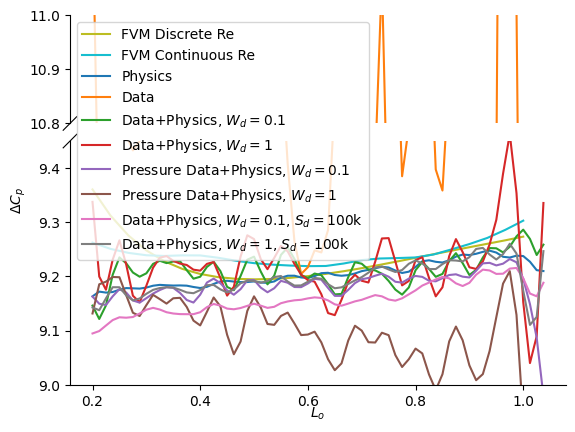

In [19]:
# Read Response Results broken axis


import csv
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from shortNames import shortNameDict
# resultsFilePath="./resultsOpt.csv"

# dirSkip = ["dataOnly1800@500k", "pressureDataPlusPhysicsLambda1@500k", ""]
dirSkip = []

resultsPath = "./responseResults/"

# models = listdir(resultsPath)
# models.sort()

models = ["physicsOnly@500k", "dataOnly1800@500k", "data1800PlusPhysicsLambda01@500k", "data1800PlusPhysicsLambda1@500k", "pressureDataPlusPhysicsLambda01@500k", "pressureDataPlusPhysicsLambda1@500k",
"data1800PlusPhysicsLambda01@100k2pO@500k", "data1800PlusPhysicsLambda1@100k2pO@500k"]

# models = ["physicsOnlyFC@500k", "dataOnly1800FC@500k", "data1800PlusPhysicsLambda01FC@500k", "data1800PlusPhysicsLambda1FC@500k", "pressureDataPlusPhysicsLambda01FC@500k", "pressureDataPlusPhysicsLambda1FC@500k"]


yLimUp = [10.8, 11]
yLim = [9.0, 9.45]

# yLimUp = [9.15, 9.4]
# yLim = [8.6, 8.7]

# for L in ["1", "0.1"]:
for reNr in [800]:
    # for HoV in [0.35, 0.4, 0.45]:
    for HoV in [0.35]:
    # for HoV in [0.2, 0.3, 0.4]:
        title = "Response $\Delta C_p$, Re = " + str(reNr) + ", Ho = " + str(HoV) # + ", $W_d$ = " + L
        plt.figure()
        # plt.title(title)
        bax = brokenaxes(ylims=((yLim[0], yLim[1]), (yLimUp[0], yLimUp[1])), hspace=.1)
        
        #plot ansys response for comparison
        ansysFilePath = "./AnsysResponseRe" + str(reNr) + "Ho" + str(HoV) + ".csv"
        with open(ansysFilePath, "r") as ansysFile:
            x_vals_ans = []
            y_vals_ans = []
            reader = csv.reader(ansysFile, delimiter=",")
            for i in range(8):
                    reader.__next__()
            for row in reader:
                x_vals_ans.append(float(row[0]))
                y_vals_ans.append(float(row[1]))
        
        bax.plot(x_vals_ans, y_vals_ans, label="FVM Discrete Re", color='tab:olive')
        
        ansysFilePath = "./AnsysResponse100Re" + str(reNr) + "Ho" + str(HoV) + ".csv"
        with open(ansysFilePath, "r") as ansysFile:
            x_vals_ans = []
            y_vals_ans = []
            reader = csv.reader(ansysFile, delimiter=",")
            for i in range(8):
                    reader.__next__()
            for row in reader:
                x_vals_ans.append(float(row[0]))
                y_vals_ans.append(float(row[1]))
        
        bax.plot(x_vals_ans, y_vals_ans, label="FVM Continuous Re", color='tab:cyan')

        #plot response for modulus models
        for model in models:
            if model in dirSkip or "100k" in model.split("@")[-1] or "300k" in model.split("@")[-1] or 'FC' in model or '300k' in model.split("@")[-2]:
            # if model in dirSkip or "100k" in model.split("@")[-1] or "300k" in model.split("@")[-1] or 'FC' not in model: #or "300k" in model.split("@")[-2]
            # if model in dirSkip or 'FC' not in model:
            # if model in dirSkip or ("Lambda" + L.replace(".", "") not in model and "data" in model):
                print("skipping ", model)
                continue
            
            path = resultsPath + model

            designs = np.load(path + "/designsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
            results = np.load(path + "/resultsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
            
            # designs = np.load(path + "/designsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")
            # results = np.load(path + "/resultsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")

            x_vals = [val[0] for val in designs]
            # x_vals = [val[1] for val in designs]
            
            modelStrSplit = model.split("@")
            
            # print(modelStrSplit)
            
            if len(modelStrSplit) == 3:
                label = shortNameDict[modelStrSplit[0]] + ", $S_d=$" + modelStrSplit[1].split("k")[0] + "k" #+ shortNameDict[modelStrSplit[1].split("k")[-1]] #+ "@" + modelStrSplit[-1]
            elif len(modelStrSplit) == 2:
                label = shortNameDict[modelStrSplit[0]] #+ "@" + modelStrSplit[-1]
            
            label = label.replace('Fully Connected, ', '').replace('Fourier, ', '')
            
            bax.plot(x_vals, results, label=label)

        pre= 'F_'
            
        bax.legend(loc='upper left')
        bax.set_xlabel("$L_o$")
        bax.set_ylabel("$\Delta C_p$")
        # plt.ylim(8.7, 9.7)
        plt.savefig(pre + 'response' + ".png", dpi = 600)



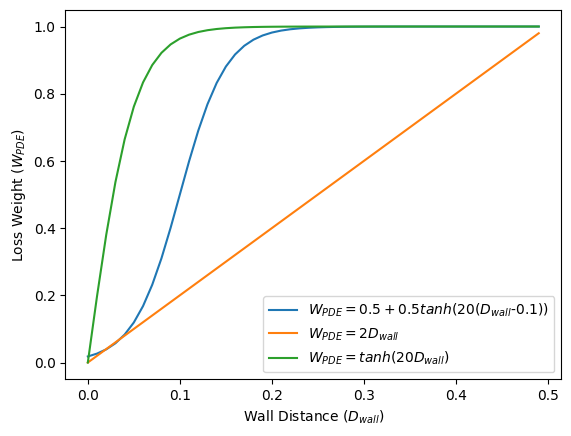

In [24]:
# plot lambda
from sympy import tanh
import matplotlib.pyplot as plt

x = np.arange(0, 0.5, 0.01)
y1 = np.array([0.5 + 0.5*tanh(20 * (xi-0.1)) for xi in x])
y2 = np.array([xi*2 for xi in x])
y3 = np.array([tanh(20 * (xi)) for xi in x])


title = "Weight for Interior (PDE) Loss"

plt.figure()
# plt.title(title)



# plt.plot(x, y1, label="0.5 + 0.5tanh(20($d_{wall}$-0.1))")
# plt.plot(x, y2, label="2$d_{wall}$")
# plt.plot(x, y3, label="tanh(20$d_{wall}$)")

plt.plot(x, y1, label="$W_{PDE} = 0.5 + 0.5tanh(20(D_{wall}$-0.1))")
plt.plot(x, y2, label="$W_{PDE} = 2D_{wall}$")
plt.plot(x, y3, label="$W_{PDE} = tanh(20D_{wall}$)")


    
    
plt.legend()
plt.xlabel("Wall Distance ($D_{wall}$)")
plt.ylabel("Loss Weight ($W_{PDE}$)")
plt.savefig("lossWeight" + ".png", dpi = 600)

In [3]:
# clean monitor directories
outputsPath = "./outputs/fwdFacingStep"
filePattern = "*/monitors/*.csv"
filePaths = glob.glob(os.path.join(outputsPath, filePattern))
for file_path in filePaths:
    if "_design_" in file_path:
        os.remove(file_path)

NameError: name 'glob' is not defined